# The HFM library - A fast marching solver with adaptive stencils

## Part : Algorithmic enhancements to the fast marching method
## Chapter : Comparison with geodesic shooting

In this chapter, we illustrate the computation of geodesics using Hamilton's equations, and compare them to those extracted with the fast marching methods.

[**Summary**](Summary.ipynb) of volume Fast Marching Methods, this series of notebooks.

[**Main summary**](../Summary.ipynb) of the Adaptive Grid Discretizations 
	book of notebooks, including the other volumes.

# Table of contents
  * [1. Isotropic metrics and the Brachistochrone problem](#1.-Isotropic-metrics-and-the-Brachistochrone-problem)



This Python&reg; notebook is intended as documentation and testing for the [HamiltonFastMarching (HFM) library](https://github.com/mirebeau/HamiltonFastMarching), which also has interfaces to the Matlab&reg; and Mathematica&reg; languages. 
More information on the HFM library in the manuscript:
* Jean-Marie Mirebeau, Jorg Portegies, "Hamiltonian Fast Marching: A numerical solver for anisotropic and non-holonomic eikonal PDEs", 2019 [(link)](https://hal.archives-ouvertes.fr/hal-01778322)

Copyright Jean-Marie Mirebeau, University Paris-Sud, CNRS, University Paris-Saclay

## 0. Importing the required libraries

In [1]:
import sys; sys.path.insert(0,"../..") # Allow import of agd from parent directory (useless if conda package installed)
#from Miscellaneous import TocTools; print(TocTools.displayTOC('HamiltonianShooting','FMM'))

In [2]:
from agd import HFMUtils
from agd import LinearParallel as lp
from agd import Metrics
from agd import AutomaticDifferentiation as ad
from agd import FiniteDifferences as fd
norm_infinity = ad.Optimization.norm_infinity
lo = ad.left_operand
from agd.Plotting import savefig; #savefig.dirName = 'Images/HamiltonianShooting'

In [3]:
import numpy as np
import scipy.integrate
from matplotlib import pyplot as plt

In [4]:
def reload_packages():
    from Miscellaneous.rreload import rreload
    global ad,lp,fd,Metrics
    ad,lp,fd,Metrics = rreload([ad,lp,fd,Metrics],rootdir="..")

## 1. Isotropic metrics and the Brachistochrone problem

A brachistochrone curve, in mathematics and physics, is a curve of fastest descent, between two points in a uniform gravity field, and neglecting friction. The standard brachistochrone problem assumes that the curve can be constructed  without constraints in free space and admits an explicit solution: the cycloid. See [Wikipedia](https://en.wikipedia.org/wiki/Brachistochrone_curve).

In this section, we recover this explicit solution numerically.
Consider a point of mass $m$, at altitude $h$, with velocity $v$, and denote by $g$ the intensity of the gravity field. The potential energy of this point is 
$$
    E = m g h + \frac 1 2 m \|v\|^2,
$$
and it is conserved along the motion, provided there is no friction.

For simplicity, but without loss of generality, we assume that $m = 1$ and $g=1$, and denote $z = -h$. Up to a vertical translation, we may also assume that the conserved energy equals zero. Then we obtain $-z+\frac 1 2 \|v\|^2=0$, equivalently
$$
    \frac {\|v\|^2}{2 z} = 1.
$$
Thus the brachistochrone problem amounts to find a geodesic, between two given points, for an isotropic metric whose (half squared) expression is given above. More explicitly, denoting by $q=(x,z)$ the position, and $v$ the speed
$$
    F_q(v) := \frac {\|v\|}{\sqrt z}.
$$

### 1.1 Explicit solution: the cycloid.
An explicit geodesic is known for the brachistochrone metric, known as the cycloid, see [Wikipedia](https://en.wikipedia.org/wiki/Brachistochrone_curve), and reading
$$
    (x(t),z(t)) = (t-\sin t, 1-\cos t),
$$
for $t \in ]0,2 \pi[$.
All other geodesics are dilations and horizontal translations of this particular solution $\gamma(t)=(x(t),z(t))$
$$
    \lambda \gamma(t/\lambda) + (x_0,0),
$$
where $\lambda>0$ and $x_0 \in R$.

In [5]:
def Cycloid(t): return ad.array((t-np.sin(t),1.-np.cos(t)))

Note : recall that the vertical axis is reversed, a.k.a. $z=-h$, w.r.t the physical brachistochrone problem.

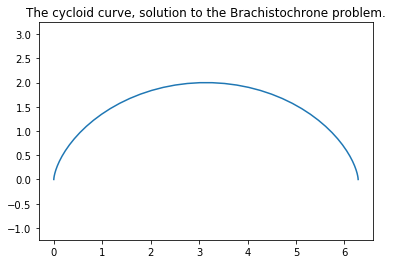

In [6]:
plt.title('The cycloid curve, solution to the Brachistochrone problem.')
plt.axis('equal')
T = np.linspace(0,2*np.pi)
plt.plot(*Cycloid(T));

### 1.2 Numerical solution using the fast marching method

In [7]:
hfmIn = HFMUtils.dictIn({
    'model':'Isotropic2',
    'arrayOrdering':'RowMajor',
    'seeds': [Cycloid(0.2)],
    'tips': [Cycloid(2.*np.pi-0.2)]
})
hfmIn.SetRect([[0,2.*np.pi],[0,2.1]],dimx=300)
X,Z = hfmIn.Grid()

In [8]:
hfmIn['cost'] = Metrics.Isotropic(1/np.sqrt(Z))

In [9]:
hfmOut = hfmIn.RunSmart()

Field verbosity defaults to 1
Field order defaults to 1
Field seedRadius defaults to 0
Field factoringMethod defaults to None
Fast marching solver completed in 0.228426 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45
Field exportValues defaults to 0


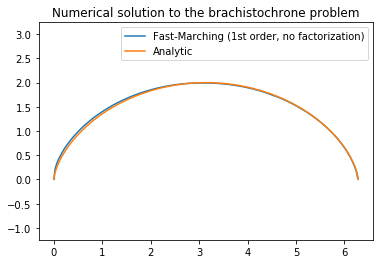

In [10]:
plt.title("Numerical solution to the brachistochrone problem") 
plt.plot(*hfmOut['geodesics'][0],label="Fast-Marching (1st order, no factorization)")
plt.plot(*Cycloid(T),label="Analytic")
plt.axis('equal'); plt.legend();

### 1.3 Geodesic shooting

Recall that the Hamiltonian is defined as the half square dual metric. For the brachistochrone, it reads
$$
    H(q,p) := \frac z 2 \|p\|^2,
$$
where $q=(x,z)$ is the position, and $p$ is the momentum. In this simple case, the velocity and momentum at a point $q=(x,z)$ are related by the equation
$$
    v = \frac {\partial H}{\partial p} = z p.
$$

In [11]:
def Brach_A_(q,p):
    """Analytic Hamiltonian for the brachistochrone problem"""
    return lo(q[1]/2.) * (p**2).sum()
Brach_A = Metrics.Hamiltonian(Brach_A_)

**Note on the use of `lo = ad.left_operand`.** See help of this function, or the notebook [ADBugs](../../Notebooks_Algo/ADBugs.ipynb).

In [20]:
help(lo)

Help on function left_operand in module agd.AutomaticDifferentiation:

left_operand(data, iterables=())
    Turns numpy scalars into zero-dimensional arrays, suitable as 
    left operands in AD operations



In [12]:
Brach_I = Metrics.Hamiltonian(hfmIn['cost'],grid=hfmIn.Grid())

In [13]:
Cycloid(ad.Dense.identity(constant=0.2)).gradient(0)

array([0.01993342, 0.19866933])

In [14]:
t_ad = ad.Dense.identity(constant=0.2)
Cyc_ad = Cycloid(t_ad)
q0 = Cyc_ad.value
v0 = Cyc_ad.gradient(0) # Initial velocity
p0 = v0/q0[1] # Initial impulsion

print(f"Exact hamiltonian flow: {Brach_A.flow(q0,p0)}")
print(f"Interpolated hamiltonian flow: {Brach_I.flow(q0,p0)}")

Exact hamiltonian flow: (array([0.01993342, 0.19866933]), array([ -0.        , -50.16700053]))
Interpolated hamiltonian flow: (array([0.01887788, 0.18814912]), array([ 6.12202307e-15, -4.59217793e+01]))


In [15]:
def f(y,t):
    return np.concatenate(Brach_A.flow(y[:2],y[2:]))
QP = scipy.integrate.odeint(f,np.concatenate((q0,p0)),np.linspace(0,2*np.pi-0.4))

In [16]:
QP2 = scipy.integrate.odeint(Brach_A.flow_cat,np.concatenate((q0,p0)),np.linspace(0,2*np.pi-0.4))

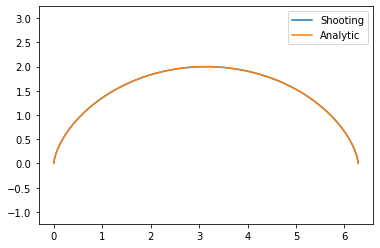

In [18]:
plt.plot(*QP2[:,:2].T,label="Shooting")
plt.plot(*Cycloid(T),label="Analytic")
plt.axis('equal'); plt.legend();

In [39]:
Brach_I.DqH(q0,p0)

array([[-1.02672987e-14,  0.00000000e+00],
       [ 0.00000000e+00,  4.59217793e+01]])

In [54]:
interp = Brach_I._H.interpolation_data[0]
interp(*q0)

0.13739679723492032

In [46]:
hfmIn.Grid().shape

(2, 300, 100)

In [51]:
interp2 = fd.UniformGridInterpolator(hfmIn.Grid(),hfmIn['cost'].cost)
interp2(q0.reshape(1,2))

array([[8.67944893, 7.63865368]])

In [53]:
hfmIn['cost'].cost.shape

(300, 100)